In [1]:
import cv2
import getpass
import chassisml
import pickle
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

## Enter credentials
Dockerhub creds and Modzy API Key

In [2]:
dockerhub_user = getpass.getpass('docker hub username')
dockerhub_pass = getpass.getpass('docker hub password')
modzy_api_key = getpass.getpass('modzy api key')

docker hub username········
docker hub password········
modzy api key········


## Train Model
This notebook will train a basic sentiment analysis model on the IMDB dataset to determine whether movie reviews are positive or negative. You can find the full Tensorflow tutorial [here](https://www.tensorflow.org/tutorials/keras/classification)

In [3]:
# load dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

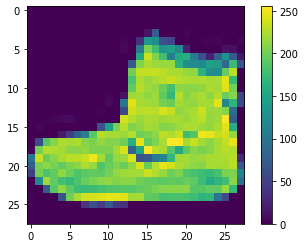

In [5]:
# visualize a sample training image
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

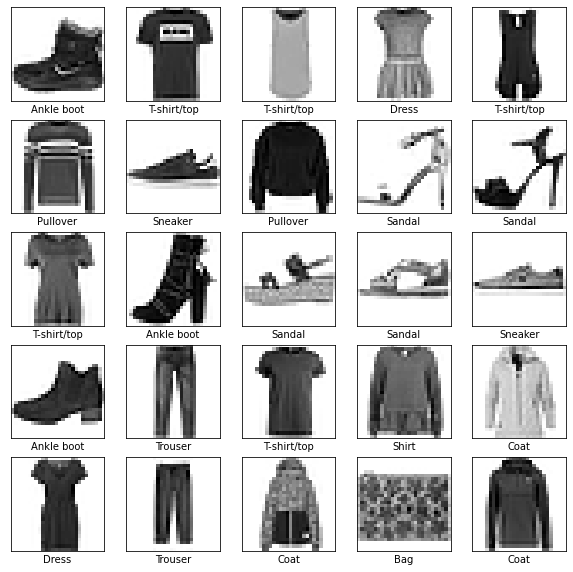

In [6]:
# preprocess data
train_images = train_images / 255.0
test_images = test_images / 255.0
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [9]:
# save image for testing later
img = test_images[0] * 255
pil_img = Image.fromarray(img).convert("RGB")
pil_img.save("./data/sample_mnist_fashion.png")

In [10]:
# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
# train model
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5001 - accuracy: 0.8254
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3752 - accuracy: 0.8644
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3380 - accuracy: 0.8755: 0s - loss: 0.3390 - accu
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3125 - accuracy: 0.8854
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2969 - accuracy: 0.8907
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2808 - accuracy: 0.8944
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2676 - accuracy: 0.9005
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2583 - accuracy: 0.9044
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2483 - accuracy: 0.9067
Epoch 10/10
1875/1875 [==============================] -

In [12]:
# evaluate accuracy
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3391 - accuracy: 0.8823 - 362ms/epoch - 1ms/step

Test accuracy: 0.8823000192642212


In [13]:
# append softmax layer to model
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

## Prepare context dict
Initialize anything here that should persist across inference runs

In [19]:
context = {
    "model": model,
    "labels": class_names,
}

## Write process function

* Must take bytes and context dict as input
* Preprocess bytes, run inference, postprocess model output, return results

In [20]:
def process(input_bytes,context):
    
    # preprocess
    img = cv2.cvtColor(cv2.imdecode(np.frombuffer(input_bytes, np.uint8), -1), cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(img, 0)
    img = img / 255
    
    # run inference
    predictions = context['model'].predict(img)
    
    # postprocess
    top_five_indices = np.argsort(predictions[0])[::-1][:5]

    inference_result = {
        "classPredictions": [
            {"class": context['labels'][idx], "score": predictions[0][idx].item()}
        for idx in top_five_indices ]
    }

    structured_output = {
        "data": {
            "result": inference_result,
            "explanation": None,
            "drift": None,
        }
    }
    
    return structured_output

## Initialize Chassis Client
We'll use this to interact with the Chassis service

In [21]:
chassis_client = chassisml.ChassisClient("http://localhost:5000")

## Create and test Chassis model
* Requires `context` dict containing all variables which should be loaded once and persist across inferences
* Requires `process_fn` defined above

In [22]:
# create Chassis model
chassis_model = chassis_client.create_model(context=context,process_fn=process)

# test Chassis model (can pass filepath, bufferedreader, bytes, or text here):
sample_filepath = './data/sample_mnist_fashion.png'
results = chassis_model.test(sample_filepath)
print(results)

b'{"data":{"result":{"classPredictions":[{"class":"Ankle boot","score":4.67133092880249},{"class":"Sneaker","score":0.6379338502883911},{"class":"Sandal","score":-1.162994623184204},{"class":"Bag","score":-6.957272052764893},{"class":"T-shirt/top","score":-9.416755676269531}]},"explanation":null,"drift":null}}'


In [23]:
# test environment and model within Chassis service, must pass filepath here:
test_env_result = chassis_model.test_env(sample_filepath)
print(test_env_result)

INFO:tensorflow:Assets written to: ram://082db61f-1a59-45ed-8b82-0ee8f7558f58/assets


NotFoundError: 

## Publish model to Modzy
Need to provide model name, model version, Dockerhub credentials, and required Modzy info

In [133]:
response = chassis_model.publish(
    model_name="PyTorch ResNet50 Image Classification",
    model_version="0.0.1",
    registry_user=dockerhub_user,
    registry_pass=dockerhub_pass,
    modzy_sample_input_path=sample_filepath,
    modzy_api_key=modzy_api_key
)

job_id = response.get('job_id')
final_status = chassis_client.block_until_complete(job_id)

INFO:tensorflow:Assets written to: ram://f34f1dca-41c9-4070-8890-d01c334fdf6b/assets



UnboundLocalError: local variable 'tmppath' referenced before assignment

In [ ]:
if chassis_client.get_job_status(job_id)["result"] is not None:
    print("New model URL: {}".format(chassis_client.get_job_status(job_id)["result"]["container_url"]))
else:
    print("Chassis job failed \n\n {}".format(chassis_client.get_job_status(job_id)))

## Run sample job
Submit inference job to our newly-deploy model running on Modzy

In [ ]:
from modzy import ApiClient

client = ApiClient(base_url='https://integration.modzy.engineering/api', api_key=modzy_api_key)

input_name = final_status['result']['inputs'][0]['name']
model_id = final_status['result'].get("model").get("modelId")
model_version = final_status['result'].get("version")

inference_job = client.jobs.submit_file(model_id, model_version, {input_name: sample_filepath})
inference_job_result = client.results.block_until_complete(inference_job, timeout=None)
inference_job_results_json = inference_job_result.get_first_outputs()['results.json']
print(inference_job_results_json)